# Notebook: pyolimp - Примеры предкомпенсации

### <span style="color:#e74c3c;">Данный Jupyter-ноутбук включён исключительно как документация-пример; запуск его ячеек не предполагается.</span>

- Готовые скрипты-примеры хранятся в пакете olimp.examples.

- Пошаговый пример их запуска показан внутри этого ноутбука.

### 📦 Импорт библиотек

В этом разделе выполняется импорт необходимых модулей:

- `sys` — для добавления пути к корню проекта;
- `torch.Tensor` — работа с тензорами в PyTorch;
- `Callable` — тип аннотации из `typing`;
- `scale_value`, `fft_conv` — функции обработки изображений из модуля `olimp.processing`;
- `demo`, `demo_cvd` — утилиты для демонстрации предкомпенсации изображений.

In [1]:
import sys
sys.path.append("../../../")

In [2]:
from typing import Callable
from torch import Tensor
from olimp.processing import scale_value, fft_conv
from olimp.precompensation._demo import demo
from olimp.precompensation._demo_cvd import demo as demo_cvd

### Метод Huang

Метод Huang — численный алгоритм предкомпенсации, основанный на **фильтре Винера**,  
используемый для восстановления изображений, искажённых аберрациями зрения (PSF).  
Он не требует обучения и применяется как базовый метод для оценки эффективности нейросетевых подходов.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение, нормализованное в диапазоне [0, 1].

📖 Подробнее: Jian Huang,  
*Dynamic Image Precompensation for Improving Visual Performance of Computer Users with Ocular Aberrations*,  
Master's Thesis, Florida International University, 18 июня 2013.  
[Скачать PDF](https://digitalcommons.fiu.edu/cgi/viewcontent.cgi?article=2021&context=etd)

Output()

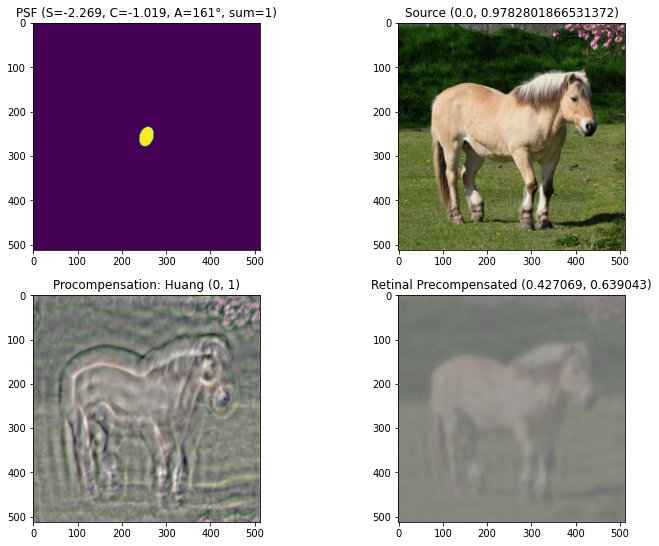

In [3]:
from olimp.precompensation.basic.huang import huang


def demo_huang(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    ret = huang(image, psf)
    progress(1.0)
    return scale_value(ret, min_val=0, max_val=1.0)


demo("Huang", demo_huang, mono=False)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation.huang

### Метод Feng Xu

Метод Feng Xu — численный алгоритм предкомпенсации, разработанный для вычислений в **реальном времени**  
и оптимизированный для **GPU-вычислений**. Основан на **L2-деконволюции** в частотной области (FFT)  
с параметром регуляризации `λ`, позволяющим контролировать диапазон значений пикселей.

**Вход:**
- изображение;
- PSF (функция рассеяния точки);
- параметр регуляризации `lambda_val` (например, λ = 2).

**Выход:**
- предкомпенсированное изображение (может быть нормализовано или дополнительно обработано).

📖 Подробнее: Feng Xu,  
*Software Based Visual Aberration Correction for HMDs*, IEEE VR, март 2018.  
[Скачать PDF](https://www.cs.ucf.edu/courses/cap6121/spr2024/readings/Xu2018.pdf)

Output()

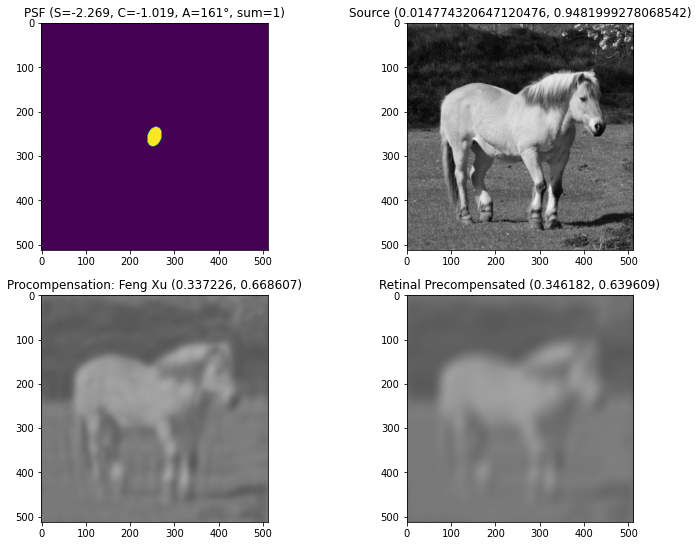

In [4]:
from olimp.precompensation.analytics.feng_xu import feng_xu


def demo_huang(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    ret = feng_xu(image, psf, lambda_val=2)
    progress(0.8)
    ret = fft_conv(scale_value(ret), psf)
    progress(1.0)
    return ret


demo("Feng Xu", demo_huang, mono=True)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation.feng_xu

### Метод Bregman Jumbo

Метод Bregman Jumbo — численный алгоритм оптимизации, основанный на **вариационной формулировке задачи предкомпенсации**, в которой используется регуляризация с **обратной проекцией Брегмана** и решается задача минимизации с ограничениями.  
Алгоритм впервые был предложен в 2021 году, а в 2024 году был доработан авторами данной работы для повышения качества и устойчивости.

**Особенности:**
- Использует метод Брегмана для поиска решения задачи с ограничением по диапазону пикселей;
- В оригинале — решение через итеративную схему с TV-регуляризацией;
- В доработке (2024) — улучшена сходимость, добавлена адаптация параметров и альтернативная схема обновления переменных.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение.

📖 Подробнее:  
**Оригинальный метод** — Montalto et al., *JUMBO: Joint Unrolling Optimization and Model-Based Approach for Blind Image Deconvolution*, ICCV 2021.  
[Скачать PDF](https://drive.google.com/file/d/1TQs41VJY4Bw05bAOMTacS6zZx0d9tK01/view?usp=sharing)  
**Доработка** — Abgaryan A.A., Al-Kazir N.B., *Анализ и улучшение оптимизации Брегмана в задачах предкомпенсации: новые подходы и алгоритмические решения*, 2024.  
[Скачать PDF (на русском)](attachment:/mnt/data/2024_AbgaryanAA_Al_KazirNB_Analiz_i_uluchshenie_optimizatsii_Bregmana_v_zadachakh_predkompensatsii_novye_podkhody_i_algoritmicheskie_k_id3179_v2024_1219_1739_.pdf)


Output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08081359..1.0808425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0066278186..0.9857437].


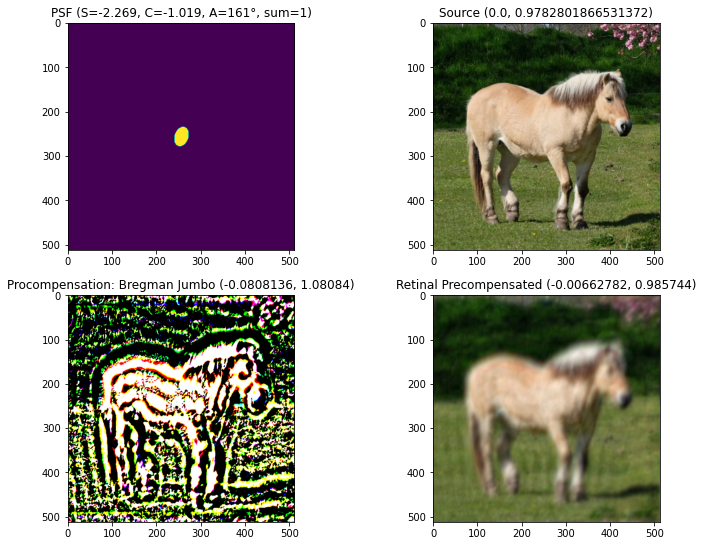

In [5]:
from olimp.precompensation.optimization.bregman_jumbo import (
    bregman_jumbo,
    BregmanJumboParameters,
)


def demo_bregman_jumbo(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    return bregman_jumbo(image, psf, BregmanJumboParameters(progress=progress))


demo("Bregman Jumbo", demo_bregman_jumbo)

Данный пример можно запустить командой:

```bash
python3 -m olimp.examples.precompensation.bregman_jumbo

### Метод Global Tone Mapping (GTM)

Метод Global Tone Mapping — численный метод глобального тонального отображения,  
разработанный для предкомпенсации изображений с учётом **рефракционных искажений зрения**.  
Он оптимизирует глобальную кривую отображения с помощью градиентного спуска,  
обеспечивая более естественную и корректную передачу яркости и контраста после прохождения через искажающую PSF.

**Ключевые особенности:**
- Не требует обучения модели;
- Параметризованная глобальная кривая яркости оптимизируется по заданной функции потерь;
- Применяется в задачах предкомпенсации зрения с искажениями, вызванными аберрациями.

**Вход:**
- изображение;
- PSF (функция рассеяния точки);
- параметры оптимизации (`lr`, число итераций и др.).

**Выход:**
- предкомпенсированное изображение после применения глобальной тональной кривой.

📖 Подробнее:  
Al-Kazir N.B., Nikolaev I.P., Nikolaev D.P.,  
*Search for Image Quality Metrics Suitable for Assessing Images Specially Precompensated for Users with Refractive Vision Defects*,  
HSE, 2023.  
[Скачать PDF](https://publications.hse.ru/pubs/share/direct/932038377.pdf)


Output()

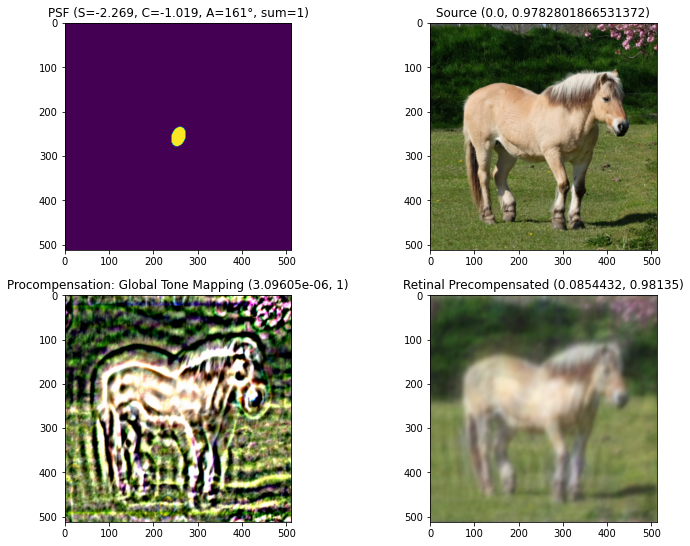

In [6]:
from olimp.precompensation.optimization.global_tone_mapping import (
    precompensation_global_tone_mapping,
    GTMParameters,
)


def demo_global_tone_mapping(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    return precompensation_global_tone_mapping(
        image, psf, GTMParameters(progress=progress, lr=0.05)
    )


demo("Global Tone Mapping", demo_global_tone_mapping, mono=False)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.global_tone_mapping

### Метод HQS (Half-Quadratic Splitting)

Метод HQS — численный итеративный алгоритм, основанный на **методе полу квадратичного разделения**,  
используется для предкомпенсации изображений, искажённых аберрациями зрения (PSF).  
Метод формулируется как задача оптимизации с двумя подзадачами:  
градиентная регуляризация и согласование с искажённым изображением.  
Он не требует обучения и решается с помощью градиентного спуска.

**Ключевые особенности:**
- Использует градиентную регуляризацию;
- Является расширением вариационных методов;
- Разделение переменных (параметров `p` и `w`) ускоряет сходимость.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение, нормализованное в диапазоне [0, 1].

📌 Публикация отсутствует (метод реализован авторами фреймворка как численный прототип).


Output()

/home/devel9393/.local/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from
a tensor, it is recommended to use sourceTensor.detach().clone() or 
sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)

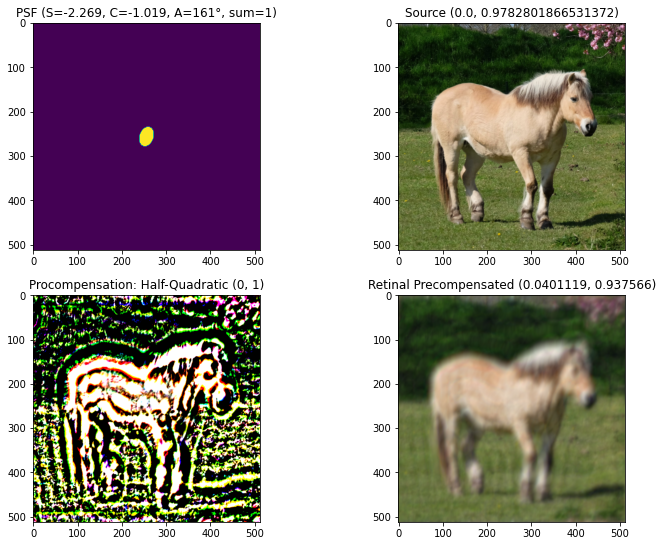

In [7]:
from olimp.precompensation.optimization.hqs import hqs, HQSParameters


def demo_hqs(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    return hqs(image, psf, HQSParameters(progress=progress))


demo("Half-Quadratic", demo_hqs)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.hqs

### Метод Ji

Метод Ji — численный алгоритм предкомпенсации, основанный на **кусочно-линейных оценках (Piecewise Linear Estimators, PLE)**  
и использующий разреженное представление градиентов изображения.  
В нашей реализации дополнительно применяется функция потерь **MS-SSIM** для более точной оптимизации в задачах восстановления.

Метод позволяет эффективно восстанавливать изображения, искажённые аберрациями зрения (PSF),  
улучшая визуальное качество по сравнению с классическими методами регуляризации.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение, нормализованное в диапазоне [0, 1].

📖 Подробнее: Hao Ji, Chao Liu, Zuowei Shen, Yinqiang Xu,  
*Efficient Image Deconvolution with Piecewise Linear Estimators*,  
CVPR 2014. [DOI: 10.1109/CVPR.2014.428](https://doi.org/10.1109/CVPR.2014.428)  
[Скачать PDF](sandbox:/mnt/data/10.1109@CVPR.2014.428.pdf)


Output()

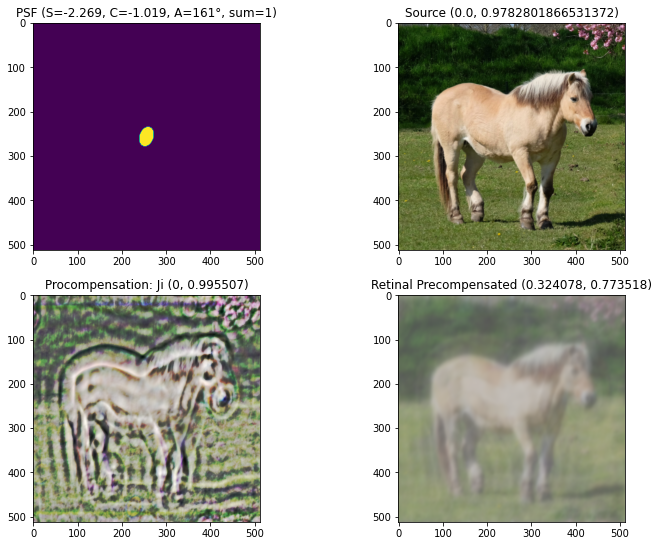

In [8]:
from olimp.precompensation.optimization.ji import ji, JiParameters
from olimp.evaluation.loss.piq import MultiScaleSSIMLoss


def demo_ji(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    return ji(
        image,
        psf,
        JiParameters(
            progress=progress, alpha=1, loss_func=MultiScaleSSIMLoss()
        ),
    )


demo("Ji", demo_ji)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.ji

### Метод Montalto (FISTA)

Метод **Montalto (FISTA)** — численный алгоритм предкомпенсации, основанный на  
ускоренной итеративной схеме **FISTA** с регуляризацией **total variation (TV)**.  
Используется для восстановления изображений, искажённых аберрациями зрения (PSF),  
обеспечивая баланс между чёткостью и устойчивостью к шуму.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение с подавленным размытием и улучшенными границами.

📖 Подробнее: Montalto et al.,  
*A Total Variation Approach for Customizing Imagery to Improve Visual Acuity*, 
ACM transactions on graphics (TOG), 2015.  
[Скачать PDF](sandbox:/mnt/data/10.1145@2717307.pdf)


Output()

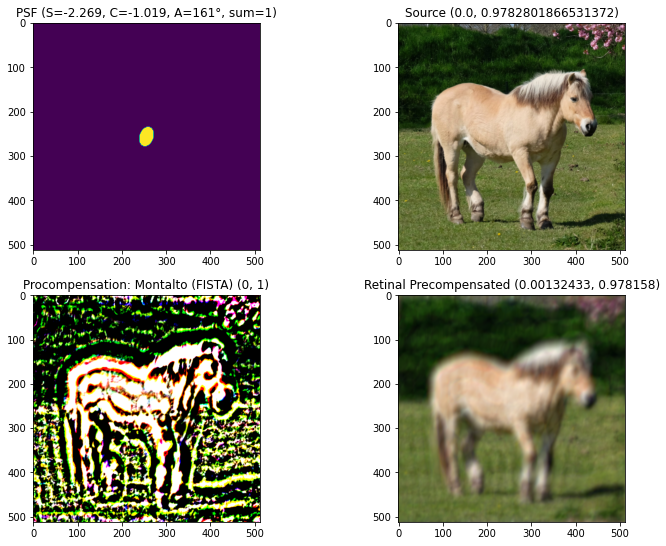

In [9]:
from olimp.precompensation.optimization.montalto_fista import (
    montalto as montalto_fista,
    MontaltoParameters as FistaMontaltoParameters,
)


def demo_montalto(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    return montalto_fista(
        image, psf, FistaMontaltoParameters(progress=progress)
    )


demo("Montalto (FISTA)", demo_montalto, mono=False)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.montalto_fista

### Метод Montalto (Adam AMSGrad)

Метод **Montalto (Adam AMSGrad)** — модификация оригинального алгоритма Montalto,  
в которой вместо метода FISTA используется оптимизатор **Adam** с флагом **AMSGrad**  
для повышения устойчивости и сходимости. Метод опирается на **регуляризацию total variation (TV)**  
и предназначен для предкомпенсации искажений, вызванных аберрациями зрения (PSF),  
улучшая резкость и субъективную чёткость изображений.

**Вход:**
- изображение;
- PSF (функция рассеяния точки).

**Выход:**
- предкомпенсированное изображение, нормализованное в диапазоне [0, 1].

📖 Подробнее:  
Montalto C. et al.  
*A Total Variation Approach for Customizing Imagery to Improve Visual Acuity*,  
ACM transactions on graphics (TOG), 2015.  
[Скачать PDF](sandbox:/mnt/data/10.1145@2717307.pdf)


Output()

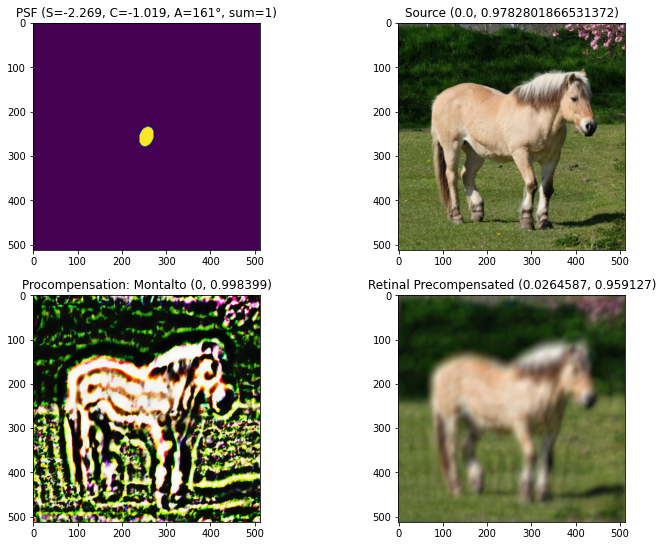

In [10]:
from olimp.precompensation.optimization.montalto import (
    montalto as montalto,
    MontaltoParameters,
)


def demo_montalto(
    image: Tensor,
    psf: Tensor,
    progress: Callable[[float], None],
) -> Tensor:
    return montalto(image, psf, MontaltoParameters(progress=progress))


demo("Montalto", demo_montalto)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.montalto

### Метод Achromatic Daltonization

Метод **Achromatic Daltonization** — это **оптимизационный алгоритм предкомпенсации**,
разработанный специально для коррекции изображений при цветовой слепоте.  
В отличие от классических методов, он формулируется как задача минимизации функционала,  
включающего структурное сходство и яркостное соответствие, и решается численно с помощью градиентного спуска.

Метод позволяет учитывать индивидуальные особенности нарушений цветового восприятия  
(протанопия, дейтеранопия и др.) и адаптировать результат под конкретный тип цветовой слепоты.

#### Вход:
- изображение;
- тип дихроматопсии (например, `protan`);
- функция искажения цвета (`ColorBlindnessDistortion`);
- параметры метода (`ADParameters`, включая функцию потерь и шаги оптимизации).

#### Выход:
- предкомпенсированное изображение (одноканальное или RGB в зависимости от настроек).

📖 Подробнее:  
- Alshammari, F., Tovée, M. J., & Westland, S.,  
**Achromatic Daltonization: A Novel Technique to Enhance Visual Information for Dichromats**,  
*Journal of Imaging*, 2023.  
[Скачать PDF](https://www.mdpi.com/2313-433X/11/7/225)


Output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].
/home/devel9393/.local/lib/python3.10/site-packages/olimp/evaluation/cs/linrgb.py:35: UserWarning: sRGB range should be in [0, 1] not [0.1196029856801033, 1.000000238418579]
  warnings.warn(


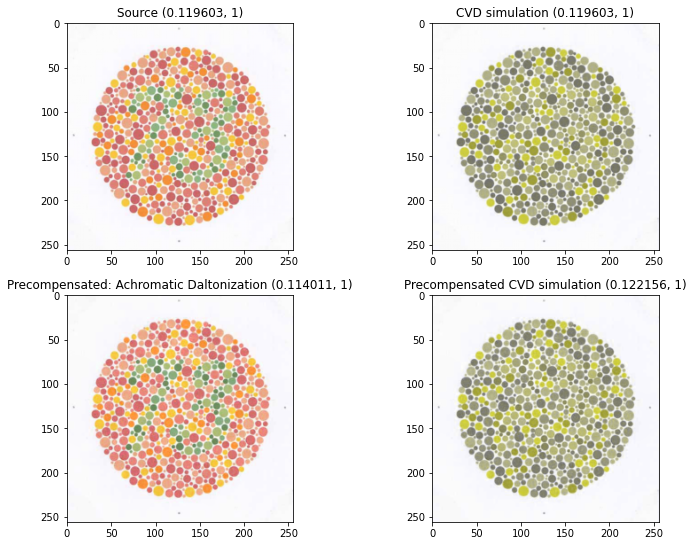

In [11]:
from olimp.precompensation.optimization.achromatic_daltonization import (
    achromatic_daltonization,
    ColorBlindnessDistortion,
    ADParameters,
    M1Loss,
)
import warnings


def demo_achromatic_daltonization(
    image: Tensor,
    distortion: ColorBlindnessDistortion,
    progress: Callable[[float], None],
) -> tuple[Tensor]:

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return (
            achromatic_daltonization(
                image,
                distortion,
                ADParameters(progress=progress, loss_func=M1Loss()),
            ),
        )


distortion = ColorBlindnessDistortion.from_type("protan")
demo_cvd(
    "Achromatic Daltonization",
    demo_achromatic_daltonization,
    distortion=distortion,
)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.achromatic_daltonization

### Метод CVD Direct Optimization

Метод CVD Direct Optimization — численная оптимизация, направленная на **персонализированную предкомпенсацию**  
дефектов цветового зрения (ДЦЗ), например протанопия, дейтеранопия. Подходит для задач, где необходимо учесть индивидуальные искажения  
зрения наблюдателя (модель `ColorBlindnessDistortion`) и корректировать изображение напрямую без обучения нейросети.

**Ключевые особенности:**
- Использует градиентный спуск с оптимизацией по карте весов (weight map);
- Потери считаются между исходным и симулированным ретинальным изображением;
- Поддерживает любые дифференцируемые функции потерь (например, RMS в Lab-пространстве);
- Реализована ранняя остановка при сходимости по шагу изменения loss.

**Вход:**
- изображение;
- модель искажения зрения (`ColorBlindnessDistortion`);
- параметры оптимизации (скорость обучения, функция потерь и т.п.).

**Выход:**
- предкомпенсированное изображение, предназначенное для наблюдателя с ДЦЗ.

🧪 Метод пока не имеет опубликованных статей, но входит в экспериментальный стек open-source фреймворка `pyolimp`.


Output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


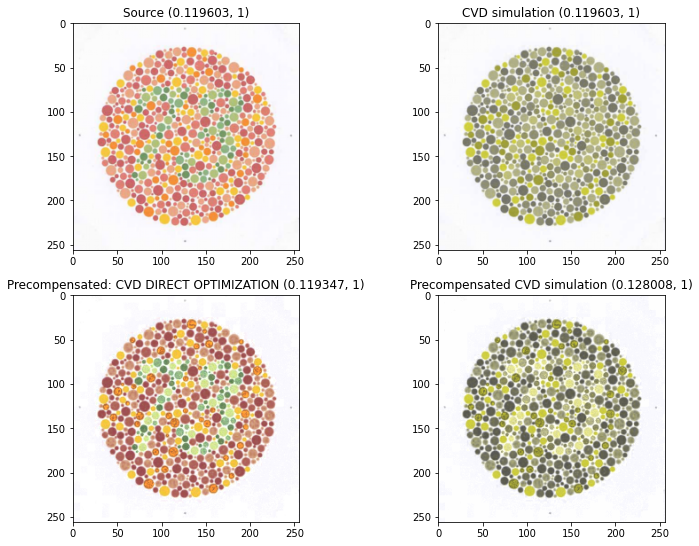

In [12]:
from olimp.precompensation.optimization.cvd_direct_optimization import (
    cvd_direct_optimization,
    CVDParameters,
)
from olimp.simulate.color_blindness_distortion import ColorBlindnessDistortion


def demo_cvd_direct_optimization(
    image: Tensor,
    distortion: ColorBlindnessDistortion,
    progress: Callable[[float], None],
) -> Tensor:
    from olimp.evaluation.loss.rms import RMS

    return (
        cvd_direct_optimization(
            image,
            distortion,
            CVDParameters(progress=progress, loss_func=RMS("lab")),
        ),
    )


distortion = ColorBlindnessDistortion.from_type("protan")
demo_cvd(
    "CVD DIRECT OPTIMIZATION",
    demo_cvd_direct_optimization,
    distortion=distortion,
)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.cvd_direct_optimization

### Метод Tennenholtz-Zachevsky

Метод **Tennenholtz-Zachevsky** предназначен для предкомпенсации изображений  
при аномалиях цветового зрения (дихроматии), таких как протанопия и дейтеранопия.  
Метод оптимизирует искажения в LMS-пространстве, минимизируя разницу между  
восприятием исходного и компенсированного изображения для наблюдателя с нарушением.

В качестве функции потерь используется разность в LMS-компонентах,  
а оптимизация проводится в пространстве изображений с применением ограничений  
на допустимые значения яркости.

**Вход:**
- изображение;
- тип цветовой аномалии (например, protan, deutan).

**Выход:**
- предкомпенсированное изображение, адаптированное под тип ДЦЗ.

📖 Подробнее:  
Tennenholtz G., Zachevsky A.  
*A Perception-Based Approach for Color Correction of Dichromats*,  
APSIPA ASC, 2019.  
[Скачать PDF](sandbox:/mnt/data/5c6023e6-9374-4916-b84e-ca7c43b58489.pdf)


Output()

/home/devel9393/.local/lib/python3.10/site-packages/olimp/evaluation/cs/linrgb.py:35: UserWarning: sRGB range 
should be in [0, 1] not [0.08746302127838135, 1.000000238418579]
  warnings.warn(

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].
/home/devel9393/.local/lib/python3.10/site-packages/olimp/evaluation/cs/linrgb.py:35: UserWarning: sRGB range should be in [0, 1] not [0.1196029856801033, 1.000000238418579]
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08746302..1.0000002].


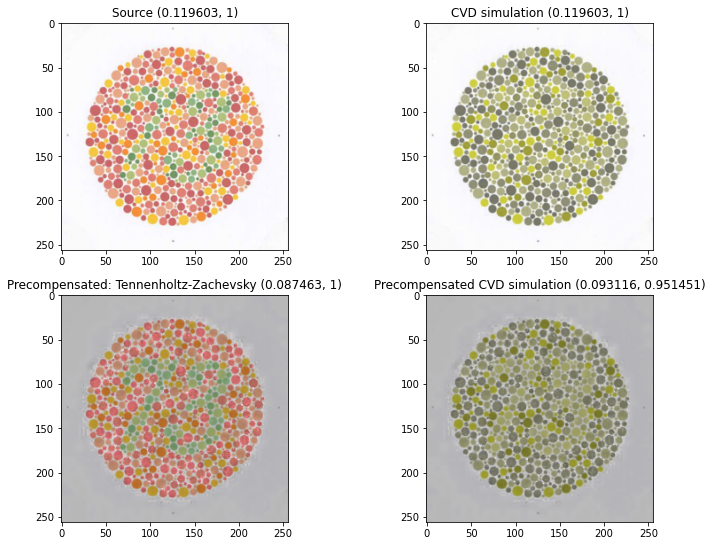

In [13]:
from olimp.precompensation.optimization.tennenholtz_zachevsky import (
    tennenholtz_zachevsky,
    TennenholtzZachevskyParameters,
)


def demo_tennenholtz_zachevsky(
    image: Tensor,
    distortion: ColorBlindnessDistortion,
    progress: Callable[[float], None],
) -> tuple[Tensor]:
    parameters = TennenholtzZachevskyParameters(progress=progress)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return (tennenholtz_zachevsky(image[0], distortion, parameters)[None],)


distortion = ColorBlindnessDistortion.from_type("protan")
demo_cvd(
    "Tennenholtz-Zachevsky",
    demo_tennenholtz_zachevsky,
    distortion=distortion,
)

Данный пример можно запустить командой:

```bash
 python3 -m olimp.examples.precompensation.tennenholtz_zachevsky